# Companion code to the paper: Incorporating Data-Driven Priors in the Maximum Entropy on the Mean Method for Linear Inverse Problems

This notebook serves as a companion to reproduce and further experiment with MEM denoising and deblurring with the MNIST dataset(s)

## Importing and vectorization of data, importing of basic packages

The data is normalized for numerical convenience. One may interchange MNIST and MNIST fashion for all the following numerics with no issue. 

In [1]:
# Importing of dataset(s)

from keras.datasets import mnist
(data, labels), (_, _) = mnist.load_data()
data = data/255;

# from keras.datasets import fashion_mnist
# (data, labels), (_, _) = fashion_mnist.load_data()
# data = data/255

# Basic Packages
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import linalg
from scipy import optimize

# Vectorization of data.
vec_data = np.zeros([np.shape(data)[0],28**2])

for i in range(np.shape(data)[0]):
    vec_data[i,:] = (data[i,:,:]).flatten();

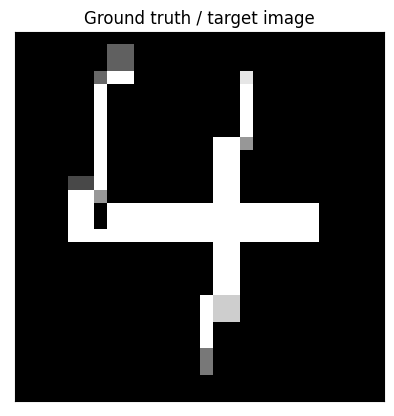

In [6]:
# One can specify an image using a filepath here
input_img  = plt.imread('C:/Users/mking/scripts/Research/MEMM_Codebase/handdrawn_images/handdrawn_4.png')

# Preprocessing may be necessary depending on the users' initial filetype.
# MNIST expects 28x28 pixel images, here normalized between 0-1

input_img = input_img[:,:,0]
img = -input_img+1
plt.imshow(img,cmap = 'gray')
img[img<0.2]=0
img[img >0.6]=img[img >0.6]+0.15
img[img>1] = 1

# Or, one may specify an image from the dataset as the target image. 
# Make suree to delete this image from the dataset if so.

#img = vec_data[0,:]
#vec_data = vec_data[1:,:]

plt.imshow(img,cmap = 'gray')
plt.yticks([]);
plt.xticks([]);
plt.title('Ground truth / target image');


# Definitions of common functions

In this code block, we define the emprirical moment generating function, log moment generating function, and its gradient.

In [4]:
def MGF(theta,data_slice):
    res = 0
    if(np.ndim(data_slice) > 1):
        n = np.size(data_slice[:,0])
        for i in range(n):
            res = res + (1/n)*np.exp(np.dot(theta,data_slice[i,:]))
    else:
        n = np.size(data_slice)
        for i in range(n):
           res = res + (1/n)*np.exp(np.dot(theta,data_slice[i]))
        
    return res

def LogMGF_deriv(theta,data_slice):
    denom = MGF(theta,data_slice)
    num = 0
    # expects a d by N matrix
    #d = size of data 
    # N = num data pints
    if(np.ndim(data_slice) > 1):
        n = np.size(data_slice[:,0])
        for i in range(n):
            num = num + data_slice[i,:]*(1/n)*np.exp(np.dot(theta,data_slice[i,:]))

    else:
        n = np.size(data_slice)
        for i in range(n):
            num = num + data_slice[i]*(1/n)*np.exp(np.dot(theta,data_slice[i]))
        
    return num/denom

def LogMGF(theta,data_slice):
    res = 0
    if(np.ndim(data_slice) > 1):
        n = np.size(data_slice[:,0])
        for i in range(n):
            res = res + (1/n)*np.exp(np.dot(theta,data_slice[i,:]))
    else:
        n = np.size(data_slice)
        for i in range(n):
           res = res + (1/n)*np.exp(np.dot(theta,data_slice[i]))
        
    return np.log(res)



def dnu(x,optimal_point,denom):
    # need to precompute for speed
    # denom = MGF(optimal_point,data_slice) 
    return np.exp(np.dot(optimal_point,x))/denom

# Experiments (MNIST digits)

## need experimental setup here

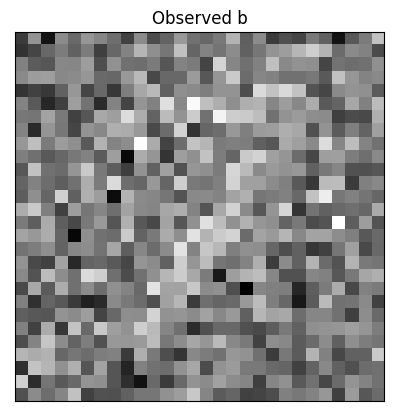

In [22]:
rng = np.random.default_rng()

# Target image, vectorized
x_true = img.flatten()

# observed b, vectorized. Here just additive noise
norm = np.linalg.norm(x_true)
b = x_true + np.random.normal(0,0.1*norm,784)


plt.figure()
plt.imshow(b.reshape(28,28),cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title('Observed b');

## User Specified Test Parameters:

In [23]:
num_data_learned = np.linspace(10000,60000,6).astype(int)
num_test = 1
alphas = [1]

## Experiment:

Note that if one simply wishes to see visual recovery, the computation of the full-data MEM solution is not needed, and can be omitted to save computational time. This uses basic BFGS "black box" from python optimize. For larger scale experiments, one should use specialized optimization routines.

Success for N=10000 and alpha = 1 over 1 tests.
Success for N=20000 and alpha = 1 over 1 tests.
Success for N=30000 and alpha = 1 over 1 tests.
Success for N=40000 and alpha = 1 over 1 tests.
Success for N=50000 and alpha = 1 over 1 tests.
Success for N=60000 and alpha = 1 over 1 tests.


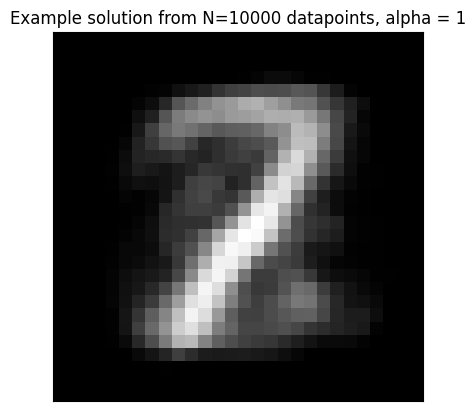

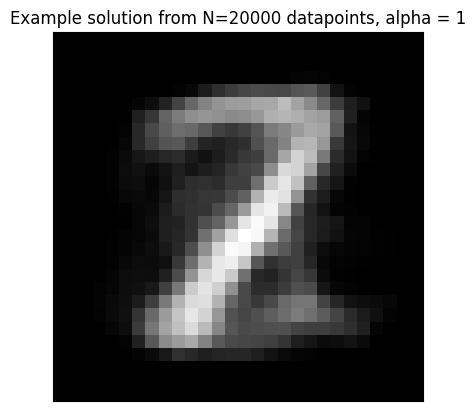

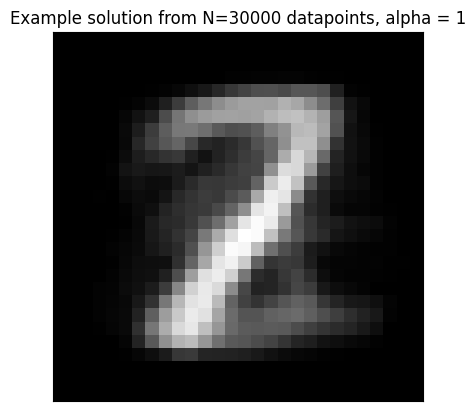

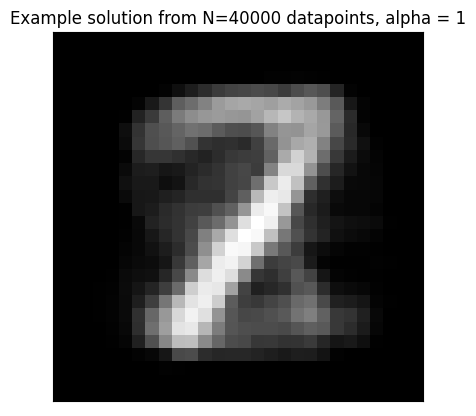

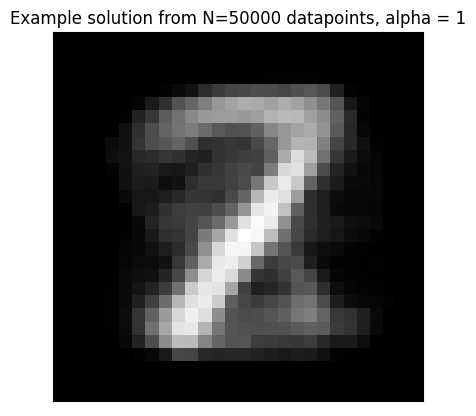

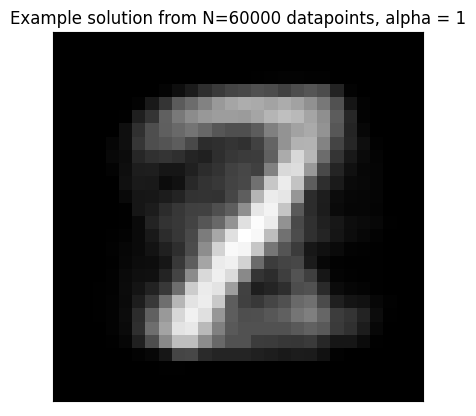

In [24]:
error_result_target = np.zeros([np.size(num_data_learned),np.size(alphas)])
error_result_true = np.zeros([np.size(num_data_learned),np.size(alphas)])

rng = np.random.default_rng()


for index_alpha,alpha in enumerate(alphas):

    # Finding target MEM reconstruction, using all the data. 
    # If one simply wishes to see visual reconstructions and not full error recovery, this is not needed.

    y_init = np.random.normal(0,1/256,28**2)
    func = lambda q: -np.dot(b,q) + (0.5)*(1/alpha)*np.linalg.norm(q)**2 + LogMGF(q,vec_data);
    grad = lambda q: -b + (1/alpha)*q +LogMGF_deriv(q,vec_data);

    result_opt = optimize.minimize(func,y_init, method='BFGS',jac = grad)


    x_target = LogMGF_deriv((result_opt.x),vec_data)
    
    for index_data,num_data in enumerate(num_data_learned):
        
        for current_test in range(num_test):

            # Randomly sample num_data datapoints
            indices = np.random.choice(vec_data.shape[0], num_data, replace=False)
            data_slice = vec_data[indices]

            # Compute solution to the dual problem
            y_init = np.random.normal(0,1/256,28**2)
            func = lambda q: -np.dot(b,q) + (0.5)*(1/alpha)*np.linalg.norm(q)**2 + LogMGF(q,data_slice);
            grad = lambda q: -b + (1/alpha)*q +LogMGF_deriv(q,data_slice);

            result_opt = optimize.minimize(func,y_init, method='BFGS',jac = grad)

            # Corresponding primal Solution
            x_final = LogMGF_deriv(result_opt.x,data_slice)

            error_result_target[index_data,index_alpha] = error_result_target[index_data,index_alpha] + np.linalg.norm(x_final - x_target)/np.linalg.norm(x_target);

        error_result_target[index_data,index_alpha] =  error_result_target[index_data,index_alpha]/num_test
        
        # PLot visually recovered image for given num_data (for one test)
        print('Success for N=' + str(num_data) + ' and alpha = ' + str(alpha) +' over ' + str(num_test) + " tests.")
        
        plt.figure()
        plt.imshow(x_final.reshape((28,28)),cmap = 'gray')
        plt.yticks([])
        plt.xticks([])
        plt.title('Example solution from N=' + str(num_data) + ' datapoints, alpha = ' + str(alpha))

## Plots of Error:

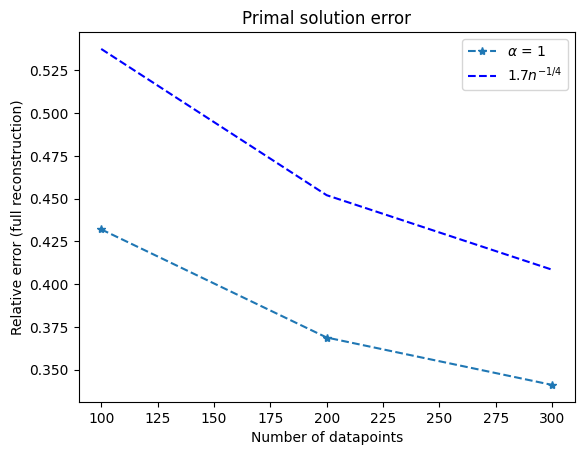

In [9]:
plt.title('Primal solution error');
plot_var =1.7*(np.power(num_data_learned,-1/4))
plt.xlabel('Number of datapoints');
plt.ylabel('Relative error (full reconstruction)');
for i in np.arange(np.size(alphas)):
    plt.plot(num_data_learned,error_result_target[:,i],'*--', label = r'$\alpha$ = ' + str(alphas[i]));
    
plt.plot(num_data_learned,plot_var,'b--', label = '$1.7n^{-1/4}$');
plt.legend();

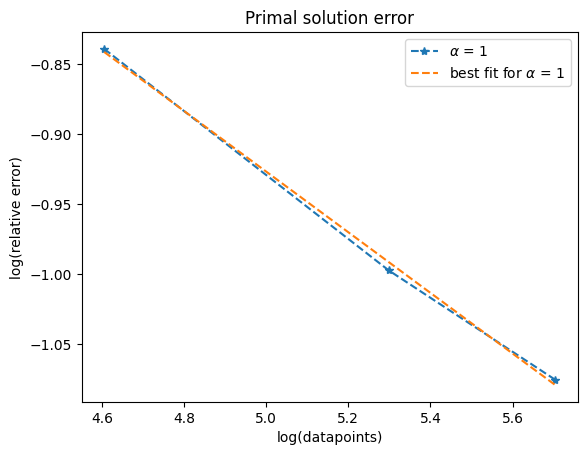

In [10]:
plt.figure()
plt.title('Primal solution error');
plot_var =1.7*(np.power(num_data_learned,-1/4))
plt.xlabel('log(datapoints)');
plt.ylabel('log(relative error)');
for i in np.arange(np.size(alphas)):
    plt.plot(np.log(num_data_learned),np.log(error_result_target[:,i]),'*--',label = r'$\alpha$ = ' + str(alphas[i]))

    z = np.polyfit(np.log(num_data_learned), np.log(error_result_target[:,i]), 1)
    plot_vals = np.polyval(z,np.log(num_data_learned))
    plt.plot(np.log(num_data_learned),plot_vals,'--',label = 'best fit for '+ r'$\alpha$ = ' + str(alphas[i]));

plt.legend();


## Post-processing: Linear combination coefficients & pixel-wise masking

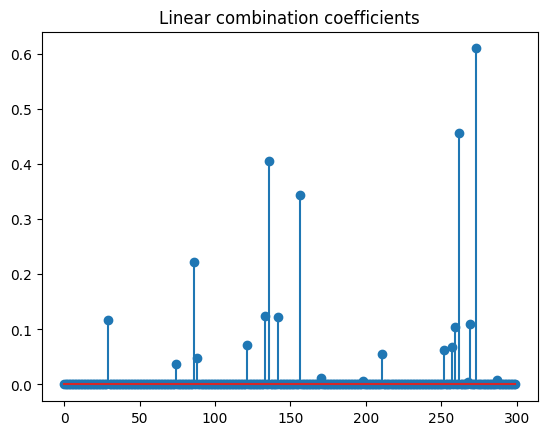

In [11]:
denom = MGF(result_opt.x,data_slice)
rho_n = np.zeros(num_data_learned[-1])
for index, current_img in enumerate(data_slice):
    rho_n[index] = dnu(current_img,result_opt.x,denom)

rho_n = rho_n/np.linalg.norm(rho_n)
plt.stem(rho_n);

plt.title("Linear combination coefficients");

(17,)


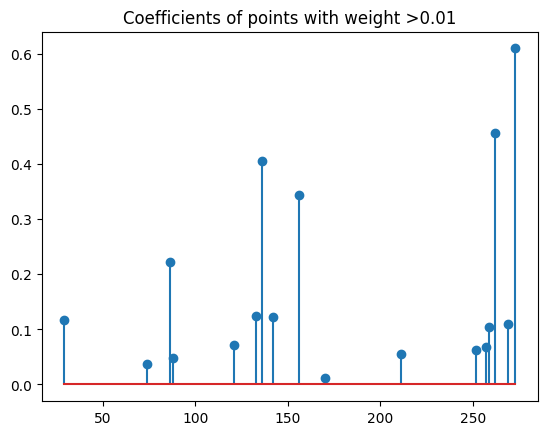

In [12]:
rho_n_cutoff = [];
indices_cutoff = [];
index_mask = 10e-3

for index, value in enumerate(rho_n):
    if(value > index_mask):
        rho_n_cutoff.append(value)
        indices_cutoff.append(index)
        
plt.title('Coefficients of points with weight >' + str(index_mask))
        
plt.stem(indices_cutoff,rho_n_cutoff);      

print(np.shape(rho_n_cutoff))

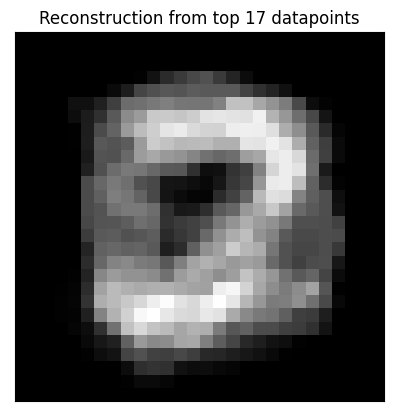

In [13]:
recon_cutoff = np.zeros_like(b)
for i in indices_cutoff:
    recon_cutoff = recon_cutoff + rho_n[i]*data_slice[i,:]
    
recon_cutoff = recon_cutoff/max(recon_cutoff)
    
plt.imshow(recon_cutoff.reshape(28,28), cmap = 'gray');
plt.xticks([]);
plt.yticks([]);
plt.title('Reconstruction from top ' + str(np.shape(rho_n_cutoff)[0]) + ' datapoints');

1.0


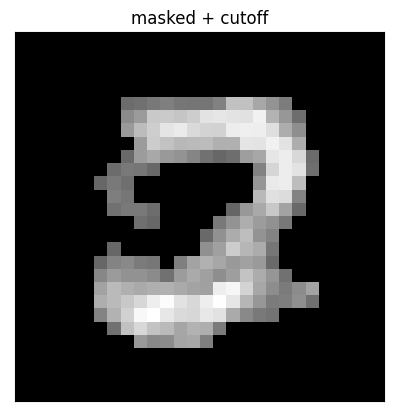

In [14]:
mask = 0.4

print(max(recon_cutoff))

cutoff_v2 = recon_cutoff.copy()

cutoff_v2[recon_cutoff <= mask] = 0
#cutoff_v2[recon_cutoff >= 1-mask] = 1

plt.imshow(cutoff_v2.reshape(28,28), cmap = 'gray');
plt.xticks([])
plt.yticks([])
plt.title('masked + cutoff');

## Nearest Neighbour for quick comparisons:

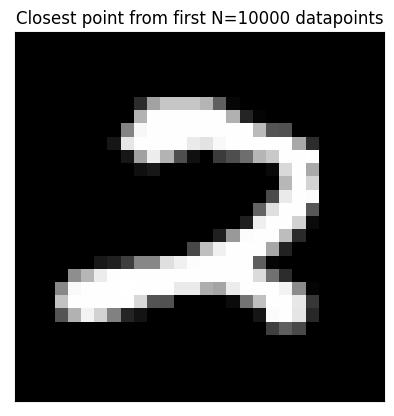

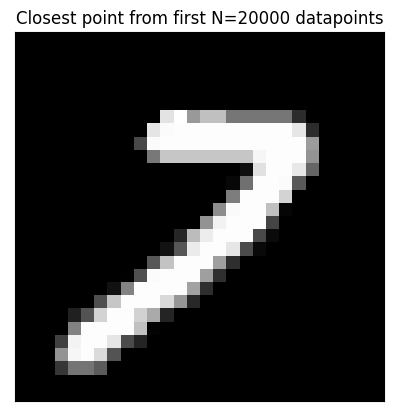

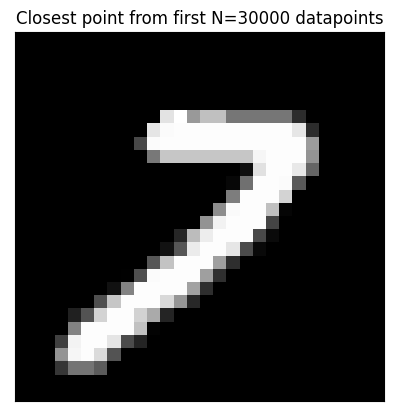

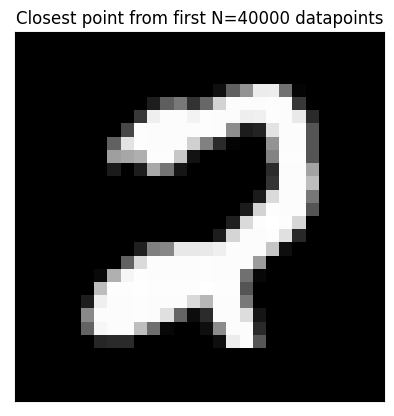

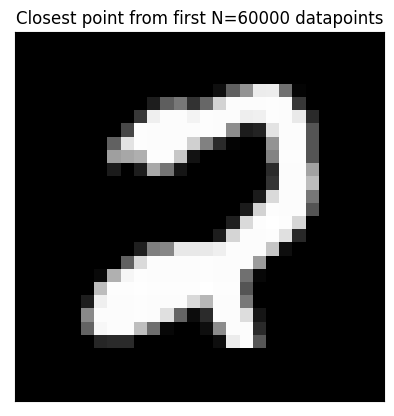

In [16]:
num_data = [10000,20000,30000,40000,60000]
data_slice = vec_data
for index_data,num in enumerate(num_data):
    
    data_slice = vec_data[:num]

    current_norm = np.inf
    closest_img = np.zeros_like(b)
    
    for i in np.arange(num):
        current_candidate = data_slice[i,:]
        if(np.linalg.norm(b-current_candidate) <= current_norm):
            closest_img = data_slice[i,:]
            current_norm = np.linalg.norm(b-current_candidate)
            
    
    plt.figure()
    plt.imshow(closest_img.reshape((28,28)),cmap = 'gray')
    plt.yticks([])
    plt.xticks([])
    plt.title('Closest point from first N=' + str(num) + ' datapoints')